# Project 2: Supervised Learning
### Building a Student Intervention System

## 1. Classification vs Regression

This is a [classification problem](http://scikit-learn.org/stable/tutorial/basic/tutorial.html) where we'll be primarily using scikit-learn tools for [supervised learning](http://scikit-learn.org/stable/tutorial/statistical_inference/supervised_learning.html).


## 2. Exploring the Data

Let's go ahead and read in the student dataset first.

_To execute a code cell, click inside it and press **Shift+Enter**._

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display # Allows the use of display() for DataFrames

In [2]:
# store inline rc to recover defaults later
# matplotlib defaults: mpl.rcParams.update(mpl.rcParamsDefault)
import matplotlib as mpl
inline_rc = dict(mpl.rcParams)

In [ ]:
# recover defaults from stored inline rc
mpl.rcParams.update(inline_rc)

In [3]:
# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"
# Note: The last column 'passed' is the target/label, all other are feature columns

Student data read successfully!


Now, can you find out the following facts about the dataset?
- Total number of students
- Number of students who passed
- Number of students who failed
- Graduation rate of the class (%age)
- Number of features

_Use the code block below to compute these values. Instructions/steps are marked using **TODO**s._

In [4]:
# TODO: Compute desired values - replace each '?' with an appropriate expression/function call
n_students = len(student_data)
n_features = len(student_data.columns[student_data.columns != 'passed'])
n_passed = len(student_data[student_data.passed == 'yes'])
n_failed = len(student_data[student_data.passed == 'no'])
grad_rate = (float(n_passed)/n_students)*100
print "Total number of students: {}".format(n_students)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Number of features: {}".format(n_features)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of students who passed: 265
Number of students who failed: 130
Number of features: 30
Graduation rate of the class: 67.09%


In [5]:
# As a benchmark for our models' training, we can use the score from predicting all "yes" values (student passed)... 

from sklearn.metrics import f1_score
print "\nF1 score for all 'yes' on students: {:.4f}".format(
    f1_score(y_true = ['yes']*n_passed + ['no']*n_failed, y_pred = ['yes']*n_students, 
             pos_label='yes', average='binary'))


F1 score for all 'yes' on students: 0.8030


Look at some features
---------------------

Some strange reporting of student absences.

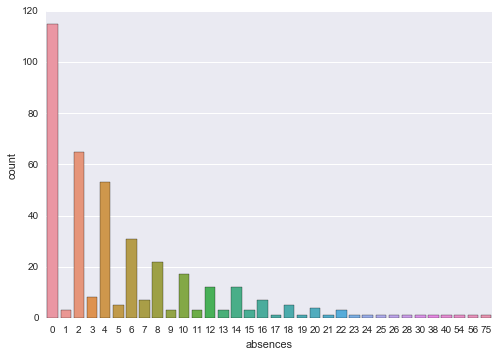

In [6]:
import seaborn as sns
df_all = student_data.copy()
_ = sns.countplot(df_all['absences'])

In [13]:
evens = df_all[(df_all.absences % 2 == 0) & (df_all.absences != 0)]['passed'].value_counts()
print "Grad rate of students with even absences: {:.2f}%".format(100.*evens[0]/(evens[0]+evens[1]), "%")

Grad rate of students with even absences: 72.80%


In [14]:
odds = df_all[df_all.absences % 2 != 0]['passed'].value_counts()
print "Grad rate of students with odd absences: {:.2f}%".format(100.*odds[0]/(odds[0]+odds[1]), "%")

Grad rate of students with odd absences: 63.41%


In [15]:
zeros = df_all[df_all.absences == 0]['passed'].value_counts()
print "Grad rate of students with 0 absences: {:.2f}%".format(100.*zeros[0]/(zeros[0]+zeros[1]))

Grad rate of students with 0 absences: 56.52%


Scatter plots
-------------

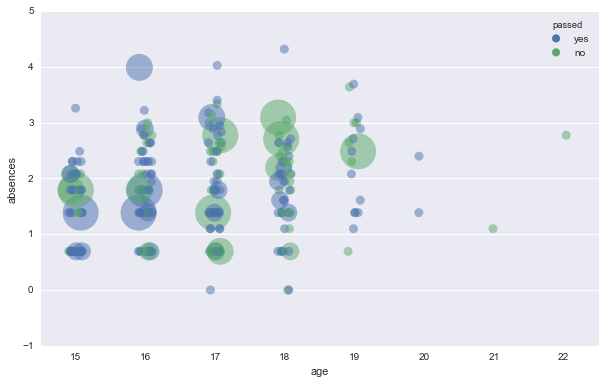

In [10]:
# scatter plot with jitter
# https://stanford.edu/~mwaskom/software/seaborn/generated/seaborn.stripplot.html
plt.figure(figsize=(10,6))
ax = sns.stripplot(x="age", y=np.log(df_all.absences), hue="passed", hue_order=['yes','no'],
                   data=df_all, jitter=.1, alpha=.5, s=9*(df_all.failures+1))

Factor plots
------------

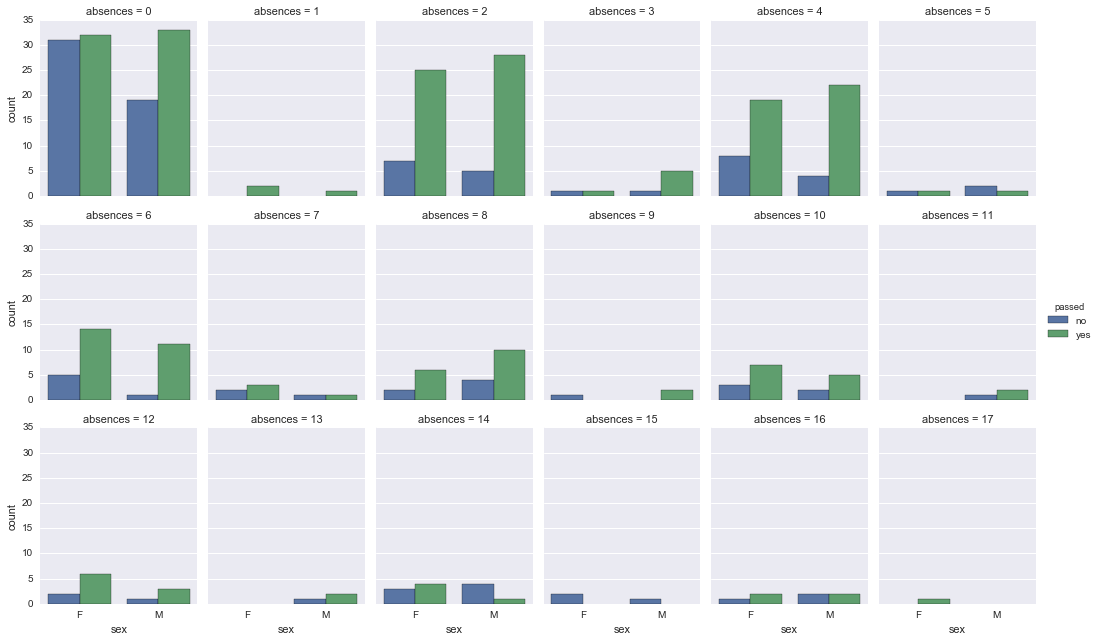

In [20]:
_ = sns.factorplot("sex", col="absences", col_wrap=6,
                   data=df_all[df_all.absences <= 17], hue='passed',
                   kind="count", size=3, aspect=.8)

Grouped Violinplots
--------

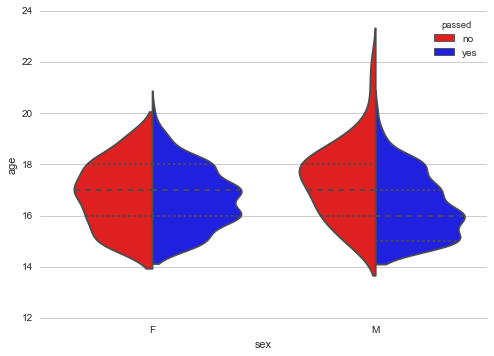

In [12]:
with sns.axes_style("whitegrid"):
    # Draw a nested violinplot and split the violins for easier comparison
    sns.violinplot(x="sex", y="age", hue="passed", data=student_data, split=True, 
                   inner="quart", palette={"yes": "b", "no": "r"})
    sns.despine(left=True)

## 3. Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Let's first separate our data into feature and target columns, and see if any features are non-numeric.<br/>
**Note**: For this dataset, the last column (`'passed'`) is the target or label we are trying to predict.

In [13]:
# Extract feature (X) and target (y) columns
feature_cols = list(student_data.columns[:-1])  # all columns but last are features
target_col = student_data.columns[-1]  # last column is the target/label
print "Feature column(s):-\n{}".format(feature_cols)
print "Target column: {}".format(target_col)

X_all = student_data[feature_cols]  # feature values for all students
y_all = student_data[target_col]  # corresponding targets/labels
print "\nFeature values:-"
display(X_all.head())

Feature column(s):-
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']
Target column: passed

Feature values:-


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,yes,no,no,4,3,4,1,1,3,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,yes,no,5,3,3,1,1,3,4
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,yes,no,4,3,2,2,3,3,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,yes,3,2,2,1,1,5,2
4,GP,F,16,U,GT3,T,3,3,other,other,...,yes,no,no,4,3,2,1,2,5,4


### Preprocess feature columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation.

In [14]:
# Preprocess feature columns
def preprocess_features(X):
    outX = pd.DataFrame(index=X.index)  # output dataframe, initially empty

    # Check each column
    for col, col_data in X.iteritems():
        # If data type is non-numeric, try to replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])
        # Note: This should change the data type for yes/no columns to int

        # If still non-numeric, convert to one or more dummy variables
        if col_data.dtype == object:
            col_data = pd.get_dummies(col_data, prefix=col)  # e.g. 'school' => 'school_GP', 'school_MS'

        outX = outX.join(col_data)  # collect column(s) in output dataframe

    return outX

X_all = preprocess_features(X_all)
print "Processed feature columns ({}):-\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48):-
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Split data into training and test sets

So far, we have converted all _categorical_ features into numeric values. In this next step, we split the data (both features and corresponding labels) into training and test sets.

In [15]:
from sklearn import cross_validation

# First, decide how many training vs test samples you want
num_all = student_data.shape[0]  # same as len(student_data)
num_train = 300  # about 75% of the data
num_test = num_all - num_train

# TODO: Then, select features (X) and corresponding labels (y) for the training and test sets
# Note: If you need a validation set, extract it from within training data
# Note: Shuffle the data or randomly select samples to avoid any bias due to ordering in the dataset
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, stratify=y_all,
                                                                     test_size=num_test, random_state=0)

print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])

print '\nTraining set grad rate: {}'.format(np.true_divide(sum(y_train=='yes'), len(y_train)))
print 'Test set grad rate: {}'.format(np.true_divide(sum(y_test=='yes'), len(y_test)))


Training set: 300 samples
Test set: 95 samples

Training set grad rate: 0.67
Test set grad rate: 0.673684210526


## 4. Training and Evaluating Models
Choose 3 supervised learning models that are available in scikit-learn, and appropriate for this problem. For each model:

- What is the theoretical O(n) time & space complexity in terms of input size?
- What are the general applications of this model? What are its strengths and weaknesses?
- Given what you know about the data so far, why did you choose this model to apply?
- Fit this model to the training data, try to predict labels (for both training and test sets), and measure the F<sub>1</sub> score. Repeat this process with different training set sizes (100, 200, 300), keeping test set constant.

Produce a table showing training time, prediction time, F<sub>1</sub> score on training set and F<sub>1</sub> score on test set, for each training set size.

Note: You need to produce 3 such tables - one for each model.

### Model #1: Logistic regression

In [17]:
# Train a model
import time

def train_classifier(clf, X_train, y_train):
    print "Training {}...".format(clf.__class__.__name__)
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    print "Done!\nTraining time (secs): {:.3f}".format(end - start)

# TODO: Choose a model, import it and instantiate an object
# Logistic regression model
from  sklearn import linear_model
clf = linear_model.LogisticRegression(random_state=0)

# Fit model to training data
train_classifier(clf, X_train, y_train)  # note: using entire training set here
#print clf  # you can inspect the learned model by printing it

Training LogisticRegression...
Done!
Training time (secs): 0.008


In [18]:
# Predict on training set and compute F1 score
from sklearn.metrics import f1_score

def predict_labels(clf, features, target):
    print "Predicting labels using {}...".format(clf.__class__.__name__)
    start = time.time()
    y_pred = clf.predict(features)
    end = time.time()
    print "Done!\nPrediction time (secs): {:.3f}".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')

train_f1_score = predict_labels(clf, X_train, y_train)
print "F1 score for training set: {:.4f}".format(train_f1_score)

Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.001
F1 score for training set: 0.8402


In [19]:
# Predict on test data
print "F1 score for test set: {:.4f}".format(predict_labels(clf, X_test, y_test))

Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.7770


In [20]:
# Train and predict using different training set sizes
def train_predict(clf, X_train, y_train, X_test, y_test):
    print "------------------------------------------"
    print "Training set size: {}".format(len(X_train))
    train_classifier(clf, X_train, y_train)
    print "F1 score for training set: {}".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {}".format(predict_labels(clf, X_test, y_test))

# TODO: Run the helper function above for desired subsets of training data
# Note: Keep the test set constant
def train_predict_size(clf, size):
    subsets = np.linspace(len(X_train)/size, len(X_train), size, dtype=int)
    for i,s in enumerate(subsets):
        train_predict(clf, X_train[:s], y_train[:s], X_test, y_test)

train_predict_size(clf, 3)

------------------------------------------
Training set size: 100
Training LogisticRegression...
Done!
Training time (secs): 0.002
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.875912408759
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.75
------------------------------------------
Training set size: 200
Training LogisticRegression...
Done!
Training time (secs): 0.002
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.853242320819
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for test set: 0.808510638298
------------------------------------------
Training set size: 300
Training LogisticRegression...
Done!
Training time (secs): 0.003
Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000
F1 score for training set: 0.840182648402
Predi

Tabular results
---------------

In [21]:
# helper function to train all the models and training set sizes
def train_predict_helper(clf, X_train, y_train, X_test, y_test):
    
    # fit training data
    start = time.time()
    clf.fit(X_train, y_train)
    end = time.time()
    
    # get training time and score
    time_train = end-start
    y_pred = clf.predict(X_train)
    f1_train = f1_score(y_train, y_pred, pos_label='yes', average='binary')
    
    # predict the test data
    start = time.time()
    y_pred = clf.predict(X_test)
    end = time.time()
    
    # get training time and score
    time_test = end-start
    f1_test = f1_score(y_test, y_pred, pos_label='yes', average='binary')
    
    return time_train, time_test, f1_train, f1_test

In [22]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from IPython.display import display # Allows the use of display() for DataFrames

# Train and predict the models
rand = 42
clf_A = linear_model.LogisticRegression(random_state=rand)
clf_B = SVC(random_state=rand)
clf_C = KNeighborsClassifier()
classifiers = [clf_A, clf_B, clf_C ]
train_sizes = [100,150,200,250,300]
clf_scores = pd.DataFrame(columns=['Training Set Size','F1 Train', 'F1 Test', 'Model'])

for clf in classifiers:
    # placeholders for our results
    numtrain=[]
    time_train=[]
    time_test=[]
    f1_train=[]
    f1_test=[]
    
    # output the name of each classifier trained
    print "\n\n{}".format(clf.__class__.__name__)
    
    for n in train_sizes:
        numtrain.append(n)
        
        # get results for the classifier with training size n
        out = train_predict_helper(clf, X_train[:n], y_train[:n], X_test, y_test)
        
        time_train.append(out[0])
        time_test.append(out[1])
        f1_train.append(out[2])
        f1_test.append(out[3])

    results={'Training Set Size':train_sizes,
             'Time to Train':time_train,
             'Time to Predict':time_test,
             'F1 Train':f1_train,
             'F1 Test':f1_test}

    df_results = pd.DataFrame(data = results, columns = ['Training Set Size','Time to Train',
                                                             'Time to Predict','F1 Train','F1 Test'])
    # show the results of models trained
    display(df_results)
    df_results['Model'] = clf.__class__.__name__
    clf_scores = clf_scores.append(df_results[['Training Set Size','F1 Train', 'F1 Test', 'Model']])



LogisticRegression


,Training Set Size,Time to Train,Time to Predict,F1 Train,F1 Test
0,100,0.005377,0.001111,0.875912,0.750000
1,150,0.001824,0.000185,0.858537,0.763359
2,200,0.001875,0.000179,0.853242,0.808511
3,250,0.002238,0.000172,0.844920,0.794326
4,300,0.002690,0.000139,0.840183,0.776978




SVC


,Training Set Size,Time to Train,Time to Predict,F1 Train,F1 Test
0,100,0.002428,0.001460,0.891892,0.773723
1,150,0.001884,0.000888,0.895928,0.782609
2,200,0.003113,0.001366,0.879479,0.818182
3,250,0.005027,0.001352,0.863636,0.807692
4,300,0.006175,0.001781,0.866379,0.828947




KNeighborsClassifier


,Training Set Size,Time to Train,Time to Predict,F1 Train,F1 Test
0,100,0.006822,0.001258,0.859155,0.791045
1,150,0.000589,0.001302,0.851852,0.779412
2,200,0.000600,0.001412,0.842466,0.794118
3,250,0.000632,0.001732,0.850949,0.785714
4,300,0.000687,0.003338,0.868778,0.771429


## Plot of training results

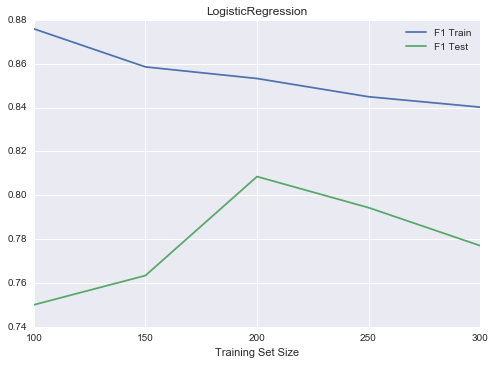

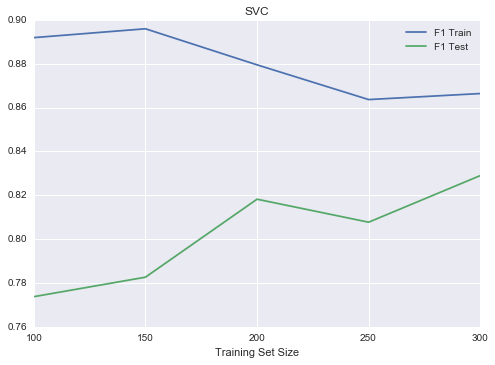

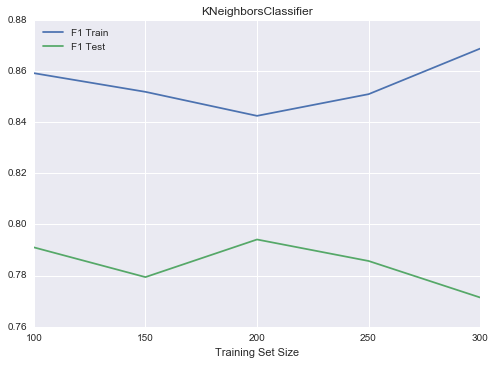

In [23]:
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    ax = clf_scores[clf_scores.Model==clf_name].plot(x='Training Set Size', 
                                                     y= ['F1 Train', 'F1 Test']);
    ax.set_title(clf_name)

Plot learning curves
---------------
http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [99]:
from sklearn.learning_curve import learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=1,
                        scorer= None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, 
        train_sizes=train_sizes, scoring=scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

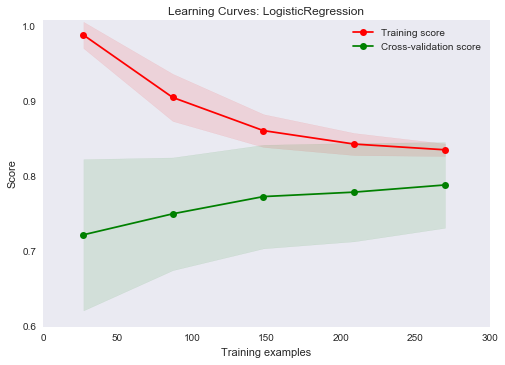

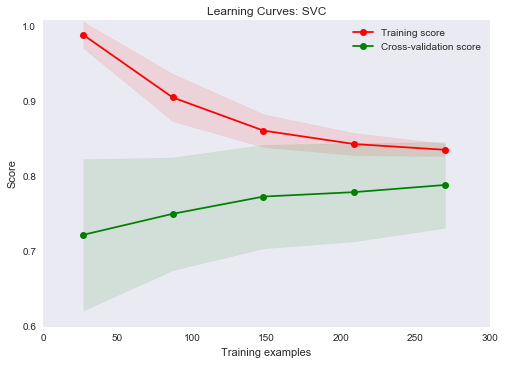

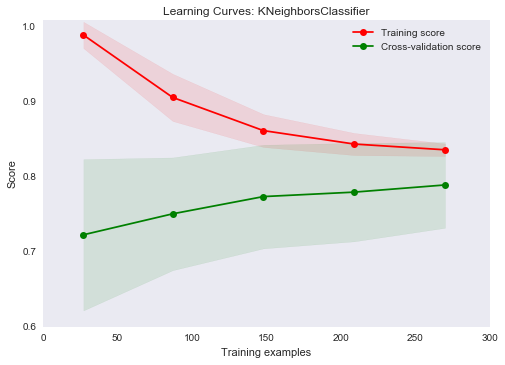

In [100]:
from sklearn.metrics import make_scorer

# Use F1 metric
f1_scorer = make_scorer(f1_score, greater_is_better=True, pos_label='yes')

# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = cross_validation.ShuffleSplit(X_train.shape[0], n_iter=100,
                                   test_size=0.1, random_state=0)

# Plot the curves
for clf in [clf_A, clf_B, clf_C]:
    title = 'Learning Curves: {}'.format(clf.__class__.__name__)
    _ = plot_learning_curve(clf_A, title, X_train, y_train, ylim=(0.6, 1.01), cv=cv, n_jobs=4, scorer=f1_scorer)

## 5. Choosing the Best Model

- Based on the experiments you performed earlier, in 1-2 paragraphs explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?
- In 1-2 paragraphs explain to the board of supervisors in layman's terms how the final model chosen is supposed to work (for example if you chose a Decision Tree or Support Vector Machine, how does it make a prediction).
- Fine-tune the model. Use Gridsearch with at least one important parameter tuned and with at least 3 settings. Use the entire training set for this.
- What is the model's final F<sub>1</sub> score?

Grid Search
=========

In [24]:
# TODO: Fine-tune your model and report the best F1 score
from sklearn import metrics
from sklearn import grid_search

# Find the best performance metric
f1_scorer = metrics.make_scorer(f1_score, greater_is_better=True, pos_label='yes')

In [26]:
# function to tune model: can specify gridsearch cv size, train/test set split via random_state
def tune_clf_model(clf, parameters, scorer, cv=None, rand=0):
    # Use gridearch to fine tune the classifier and find the best model
    reg = grid_search.GridSearchCV(clf, parameters, scoring=scorer, cv=cv)
    
    # Shuffle the data using different random_state values
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, stratify=y_all,
                                                                         test_size=int(num_test), random_state=rand)
    
    # find best estimator
    reg.fit(X_train, y_train)
    est = reg.best_estimator_
    print est, "\n"
    
    # Predict best_estimator_ on training and test data
    print "\nF1 score for training set: {}".format(predict_labels(est, X_train, y_train))
    print "\nClassification report (train):\n", metrics.classification_report(y_train, est.predict(X_train))
    print "\nF1 score for test set: {}".format(predict_labels(est, X_test, y_test))
    print "\nClassification report (test):\n", metrics.classification_report(y_test, est.predict(X_test))
    return est, reg

Grid Search: Logistic Regression
------------

In [27]:
# Setup a Classifier
clf = linear_model.LogisticRegression(random_state=42)

# tuning paramas
parameters = {'C': (10., 1., 0.5, 0.1),
              'max_iter': (100, 200, 500)}

est, reg = tune_clf_model(clf, parameters, f1_scorer)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False) 

Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000

F1 score for training set: 0.821428571429

Classification report (train):
             precision    recall  f1-score   support

         no       0.68      0.36      0.47        99
        yes       0.74      0.92      0.82       201

avg / total       0.72      0.73      0.71       300

Predicting labels using LogisticRegression...
Done!
Prediction time (secs): 0.000

F1 score for test set: 0.791666666667

Classification report (test):
             precision    recall  f1-score   support

         no       0.53      0.26      0.35        31
        yes       0.71      0.89      0.79        64

avg / total       0.65      0.68      0.65        

Look at logistic regression coeffs
----------

In [45]:
# helper function for top n coefficients of the logistic regression model
def visualize_coefficients(classifier, feature_names, n_features=10):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    pos_coeffs = np.argsort(coef)[-n_features:]
    neg_coeffs = np.argsort(coef)[:n_features]
    hmm_coeffs = np.hstack([neg_coeffs, pos_coeffs])
    
    # plot the coeefs
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[hmm_coeffs]]
    plt.bar(np.arange(20), coef[hmm_coeffs], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 21), feature_names[hmm_coeffs], rotation=35, ha="right");

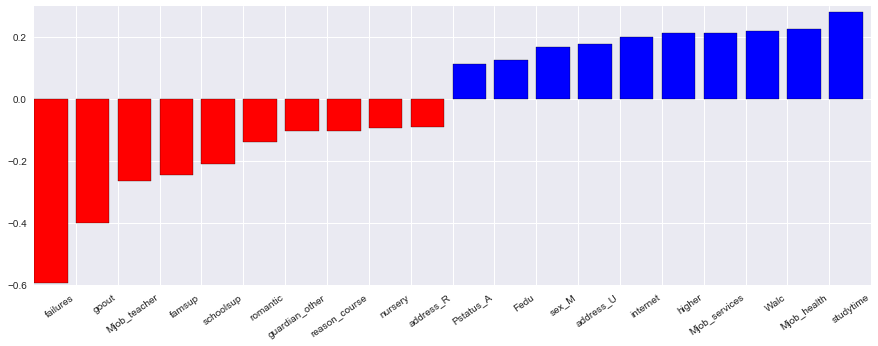

In [46]:
# look at the coeffs
visualize_coefficients(est, X_train.columns)

Grid Search: SVM
-----------
http://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html

In [23]:
# normalize features
from sklearn.preprocessing import Normalizer
normer = Normalizer()
X_train = normer.fit_transform(X_train)
X_test = normer.transform(X_test)

# Setup a Classifier
clf = svm.SVC(random_state=42)

# tune params
C_range = np.logspace(-2, 10, 6)
gamma_range = np.logspace(-9, 3, 8)
parameters = dict(gamma=gamma_range, C=C_range)

est_svm, grid_obj = tune_clf_model(clf, parameters, f1_scorer, cv=5)

SVC(C=158489.31924611109, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=5.1794746792312124e-08,
  kernel='rbf', max_iter=-1, probability=False, random_state=42,
  shrinking=True, tol=0.001, verbose=False) 

Predicting labels using SVC...
Done!
Prediction time (secs): 0.004

F1 score for training set: 0.827004219409
Classification report (train):
             precision    recall  f1-score   support

         no       0.81      0.22      0.35        99
        yes       0.72      0.98      0.83       201

avg / total       0.75      0.73      0.67       300

Predicting labels using SVC...
Done!
Prediction time (secs): 0.001

F1 score for test set: 0.81045751634
Classification report (test):
             precision    recall  f1-score   support

         no       0.67      0.13      0.22        31
        yes       0.70      0.97      0.81        64

avg / total       0.69      0.69      0.62        95



Look at SVM grid search scores
-------

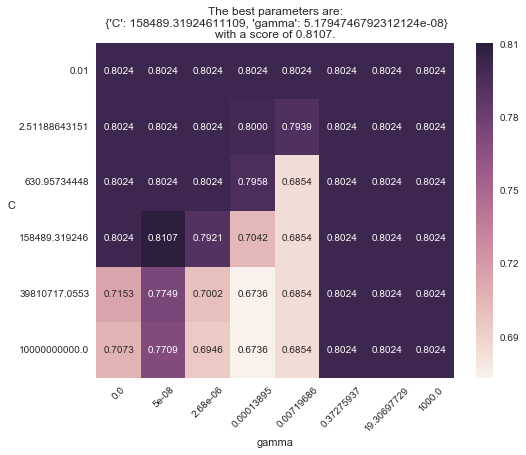

In [31]:
# heatmap of best scores
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

scores = [x[1] for x in grid_obj.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))

fig, ax = plt.subplots(figsize=(8,6))

ax = sns.heatmap(scores, annot=True, fmt=".4f")
ax.set_xlabel('gamma')
ax.set_ylabel('C', rotation=0)
ax.yaxis.labelpad = 8
ax.set_xticklabels(gamma_range.round(8), rotation=45, ha='center')
ax.set_yticklabels(C_range[::-1], rotation=0, va='center')
ax.set_title("The best parameters are:\n {}\nwith a score of {:0.4f}.".format(
        grid_obj.best_params_, grid_obj.best_score_)
         );

Grid Search: Gradient Boosting
------------

In [28]:
from sklearn.ensemble import GradientBoostingClassifier
GradientBoostingClassifier()

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [30]:
from sklearn.ensemble import GradientBoostingClassifier

# Setup a Classifier
clf = GradientBoostingClassifier(random_state=42)

# tuning paramas
parameters = {'learning_rate': (.01, .015, .02, .1),
              'subsample': (.8,.9,1.0),
              'max_depth': (3,5,9)}

est, reg = tune_clf_model(clf, parameters, f1_scorer, cv=5)

GradientBoostingClassifier(init=None, learning_rate=0.02, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=0.9, verbose=0,
              warm_start=False) 

Predicting labels using GradientBoostingClassifier...
Done!
Prediction time (secs): 0.001

F1 score for training set: 0.89841986456

Classification report (train):
             precision    recall  f1-score   support

         no       0.97      0.57      0.71        99
        yes       0.82      0.99      0.90       201

avg / total       0.87      0.85      0.84       300

Predicting labels using GradientBoostingClassifier...
Done!
Prediction time (secs): 0.000

F1 score for test set: 0.780141843972

Classification report (test):
             precision    recall  f1-score   support

         no       0.50      0.29      0.3

In [37]:
# look at grid scores
for i in reg.grid_scores_[0]:
    print i

{'subsample': 0.8, 'learning_rate': 0.01, 'max_depth': 3}
0.816190185159
[ 0.76923077  0.84210526  0.86666667  0.7816092   0.82222222]


In [52]:
# create df of grid scores & params
grid_scores = pd.DataFrame(
    [[param[parameters.keys()[0]], param[parameters.keys()[1]], param[parameters.keys()[2]], score] for param, score, _ in reg.grid_scores_], 
    columns=parameters.keys()+['score'])

grid_scores.head()

,subsample,learning_rate,max_depth,score
0,0.8,0.01,3,0.816190
1,0.9,0.01,3,0.811708
2,1.0,0.01,3,0.818460
3,0.8,0.01,5,0.813874
4,0.9,0.01,5,0.805374



---

TPOT: automating & optimizing pipelines
---------------

http://www.randalolson.com/2016/05/08/tpot-a-python-tool-for-automating-data-science/  
https://github.com/rhiever/tpot  

[Installation](http://rhiever.github.io/tpot/installing/)
1. NumPy, SciPy, pandas, and scikit-learn can be installed in Anaconda via the command:
```
conda install numpy scipy pandas scikit-learn```
2. DEAP and XGBoost can be installed with pip:
```
pip install deap xgboost```
3. Install TPOT:
```
pip install tpot```

In [119]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from tpot import TPOT
import time

''' example code
hill_valley_noisy_data = pd.read_csv('https://raw.githubusercontent.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/master/tpot-demo/Hill_Valley_with_noise.csv.gz', sep='\t', compression='gzip')  

X = hill_valley_noisy_data.drop('class', axis=1).values  
y = hill_valley_noisy_data.loc[:, 'class'].values  
 
X_train, X_test, y_train, y_test = train_test_split(X, y,  
                                                    train_size=0.75,  
                                                    test_size=0.25)  
'''

# use the preprocessed features; varying stratify, test_size, random_state
X_train, X_test, y_train, y_test = train_test_split(X_all.values, y_all.values, stratify=y_all, 
                                                    test_size=0.24, random_state=1234)

my_tpot = TPOT(generations=8)  
start = time.time()
my_tpot.fit(X_train, y_train)
end = time.time()

hours, rem = divmod(end-start, 3600)
minutes, seconds = divmod(rem, 60)
print("Training time = {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

  
print(my_tpot.score(X_test, y_test))  
print '-'*32

my_tpot.export('exported_pipeline.py')

Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x11a0c7910>> ignored
Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x11a0c7610>> ignored
Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x11a12c790>> ignored
Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x11a12cd10>> ignored
Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x11b03a7d0>> ignored
Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x11a0c7c10>> ignored
Exception 

Training time = 00:06:24.34
0.591481854839
--------------------------------


AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x11a12c290>> ignored



### Helper functions to train TPOT

In [31]:
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from tpot import TPOT
import time


# function to fit TPOT object
def train_TPOT(features=X_all, target=y_all, rand=1234, test_size=.24, gen=8):
    # use the preprocessed features; varying stratify, test_size, random_state
    X_train, X_test, y_train, y_test = train_test_split(X_all.values, y_all.values, stratify=y_all, 
                                                        test_size=test_size, random_state=rand)

    my_tpot = TPOT(generations=gen)
    start = time.time()
    my_tpot.fit(X_train, y_train)
    end = time.time()

    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Training time = {:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))


    print(my_tpot.score(X_test, y_test))  
    print '-'*32

    my_tpot.export('exported_pipeline.py')
    print 'Load pipeline with:\n%load exported_pipeline.py'
    
    return X_train, X_test, y_train, y_test
    

# function to run exported pipeline
def run_pipeline(clf=RandomForestClassifier(), features=X_all, target=y_all, rand=1234, test_size=.24):
    # NOTE: Make sure that the class is labeled 'class' in the data file
    tpot_data = pd.concat([X_all, pd.Series(y_all, name='class')], axis=1)
    training_indices, testing_indices = train_test_split(tpot_data.index,
                                                         stratify = tpot_data['class'].values,
                                                         test_size=test_size, random_state=rand)

    result1 = tpot_data.copy()

    # Perform classification
    clf.fit(result1.loc[training_indices].drop('class', axis=1).values, result1.loc[training_indices, 'class'].values)
    result1['pipe-classification'] = clf.predict(result1.drop('class', axis=1).values)
    print clf
    print metrics.classification_report(y_test, clf.predict(X_test))

### Look at the pipeline TPOT created with:
```
%load exported_pipeline.py
```

### TPOT example #1: random forest (not stratified)

In [78]:
# train/test splits when optimization found random forest classifier
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])

print '\nTraining set grad rate: {}'.format(np.true_divide(sum(y_train=='yes'), len(y_train)))
print 'Test set grad rate: {}'.format(np.true_divide(sum(y_test=='yes'), len(y_test)))

Training set: 296 samples
Test set: 99 samples

Training set grad rate: 0.675675675676
Test set grad rate: 0.656565656566


In [100]:
# optimization found: random forest
import numpy as np
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

# NOTE: Make sure that the class is labeled 'class' in the data file
tpot_data = pd.concat([X_all, pd.Series(y_all, name='class')], axis=1)
training_indices, testing_indices = train_test_split(tpot_data.index,
                                                     stratify = tpot_data['class'].values,
                                                     train_size=0.75, test_size=0.25, random_state=42)

result1 = tpot_data.copy()

# Perform classification with a random forest classifier
rfc1 = RandomForestClassifier(n_estimators=198, max_features=min(608, len(result1.columns) - 1))
rfc1.fit(result1.loc[training_indices].drop('class', axis=1).values, result1.loc[training_indices, 'class'].values)
result1['rfc1-classification'] = rfc1.predict(result1.drop('class', axis=1).values)

In [76]:
# the results below are contanimated due to different train/test splits
# during TPOT fitting and optimized rf fitting
est = rfc1
print metrics.classification_report(y_test, est.predict(X_test))

             precision    recall  f1-score   support

         no       0.94      0.91      0.93        34
        yes       0.95      0.97      0.96        65

avg / total       0.95      0.95      0.95        99



### TPO example #2: random forest (stratified)

In [120]:
# train/test splits when optimization found: random forest
print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])

print '\nTraining set grad rate: {}'.format(np.true_divide(sum(y_train=='yes'), len(y_train)))
print 'Test set grad rate: {}'.format(np.true_divide(sum(y_test=='yes'), len(y_test)))

Training set: 300 samples
Test set: 95 samples

Training set grad rate: 0.67
Test set grad rate: 0.673684210526


In [124]:
# confirm train/test splits are same
training_indices, testing_indices = train_test_split(tpot_data.index,
                                                     stratify = tpot_data['class'].values,
                                                     test_size=0.24, random_state=1234)
X_all.iloc[training_indices].head()

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
390,0,1,0,1,20,0,1,0,1,1,...,1,0,0,5,5,4,4,5,4,11
285,1,0,0,1,17,0,1,1,0,0,...,1,1,0,4,3,3,1,2,4,2
364,0,1,1,0,17,1,0,1,0,0,...,1,0,0,3,2,2,1,2,3,0
114,1,0,0,1,15,1,0,1,0,0,...,1,1,1,5,4,2,1,1,5,8
30,1,0,0,1,15,0,1,1,0,0,...,1,1,0,5,4,2,3,4,5,0


In [125]:
pd.DataFrame(X_train[:5], columns=X_all.columns)

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,0,1,0,1,20,0,1,0,1,1,...,1,0,0,5,5,4,4,5,4,11
1,1,0,0,1,17,0,1,1,0,0,...,1,1,0,4,3,3,1,2,4,2
2,0,1,1,0,17,1,0,1,0,0,...,1,0,0,3,2,2,1,2,3,0
3,1,0,0,1,15,1,0,1,0,0,...,1,1,1,5,4,2,1,1,5,8
4,1,0,0,1,15,0,1,1,0,0,...,1,1,0,5,4,2,3,4,5,0


In [130]:
# %load exported_pipeline.py
import numpy as np
import pandas as pd

from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

# NOTE: Make sure that the class is labeled 'class' in the data file
tpot_data = pd.concat([X_all, pd.Series(y_all, name='class')], axis=1)
training_indices, testing_indices = train_test_split(tpot_data.index,
                                                     stratify = tpot_data['class'].values,
                                                     test_size=0.24, random_state=1234)

result1 = tpot_data.copy()

# Perform classification with a random forest classifier
rfc2 = RandomForestClassifier(n_estimators=54, max_features=min(125, len(result1.columns) - 1))
rfc2.fit(result1.loc[training_indices].drop('class', axis=1).values, result1.loc[training_indices, 'class'].values)
result1['rfc1-classification'] = rfc1.predict(result1.drop('class', axis=1).values)
print rfc2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=48, max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=54, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


In [129]:
print metrics.classification_report(y_test, rfc2.predict(X_test))

             precision    recall  f1-score   support

         no       0.57      0.52      0.54        31
        yes       0.78      0.81      0.79        64

avg / total       0.71      0.72      0.71        95



### TPOT example #3: xgboost (stratified, features preprocessed)

In [29]:
X_all.head()

,school_GP,school_MS,sex_F,sex_M,age,address_R,address_U,famsize_GT3,famsize_LE3,Pstatus_A,...,higher,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences
0,1,0,1,0,18,0,1,1,0,1,...,1,0,0,4,3,4,1,1,3,6
1,1,0,1,0,17,0,1,1,0,0,...,1,1,0,5,3,3,1,1,3,4
2,1,0,1,0,15,0,1,0,1,0,...,1,1,0,4,3,2,2,3,3,10
3,1,0,1,0,15,0,1,1,0,0,...,1,1,1,3,2,2,1,1,5,2
4,1,0,1,0,16,0,1,1,0,0,...,1,0,0,4,3,2,1,2,5,4


In [35]:
X_train, X_test, y_train, y_test = train_TPOT(features=X_all, target=y_all, rand=1234, test_size=.24, gen=3)

Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x119e0e650>> ignored
Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x1198ca810>> ignored
Exception AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x119897f90>> ignored
Exception 

Training time = 00:01:01.09
0.516381048387
--------------------------------
Load pipeline with:
%load exported_pipeline.py


AttributeError: "'DMatrix' object has no attribute 'handle'" in <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x119dfb390>> ignored


In [38]:
# assign clf and run exported pipeline on train and test sets
from xgboost import XGBClassifier
clf = XGBClassifier(learning_rate=0.01, n_estimators=39, max_depth=100)
run_pipeline(clf, features=X_all, target=y_all, rand=1234, test_size=.24)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=100,
       min_child_weight=1, missing=None, n_estimators=39, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
             precision    recall  f1-score   support

         no       0.33      0.26      0.29        31
        yes       0.68      0.75      0.71        64

avg / total       0.56      0.59      0.57        95



---

## Predict with xgboost

In [39]:
# split training data into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.1, random_state=1234)

In [58]:
from xgboost.sklearn import XGBClassifier

# get our classifier
est = XGBClassifier(max_depth=6, learning_rate=0.25, n_estimators=250, gamma=0,
                    subsample=0.8, colsample_bytree=0.8, seed=101)

In [53]:
# change targets to 1, 0
y_test = pd.Series(y_test).replace(['yes', 'no'], [1, 0])
y_train = pd.Series(y_train).replace(['yes', 'no'], [1, 0])
y_valid = pd.Series(y_valid).replace(['yes', 'no'], [1, 0])

y_test[:5]

0    1
1    1
2    0
3    1
4    0
dtype: int64

In [59]:
# fit the model and show results for both train and valid sets
my_eval_set = [(X_train,y_train), (X_valid,y_valid)]
est.fit(X_train, y_train, eval_set=my_eval_set, early_stopping_rounds=50, eval_metric='logloss')

Will train until validation_1 error hasn't decreased in 50 rounds.
[0]	validation_0-logloss:0.621830	validation_1-logloss:0.703260
[1]	validation_0-logloss:0.555032	validation_1-logloss:0.672314
[2]	validation_0-logloss:0.498874	validation_1-logloss:0.675837
[3]	validation_0-logloss:0.457804	validation_1-logloss:0.701792
[4]	validation_0-logloss:0.426074	validation_1-logloss:0.694766
[5]	validation_0-logloss:0.397017	validation_1-logloss:0.685203
[6]	validation_0-logloss:0.371078	validation_1-logloss:0.704110
[7]	validation_0-logloss:0.343017	validation_1-logloss:0.707893
[8]	validation_0-logloss:0.323117	validation_1-logloss:0.723213
[9]	validation_0-logloss:0.304686	validation_1-logloss:0.722135
[10]	validation_0-logloss:0.291200	validation_1-logloss:0.704073
[11]	validation_0-logloss:0.277681	validation_1-logloss:0.699630
[12]	validation_0-logloss:0.265660	validation_1-logloss:0.700930
[13]	validation_0-logloss:0.254301	validation_1-logloss:0.711472
[14]	validation_0-logloss:0.23915

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.25, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=250, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=101, silent=True, subsample=0.8)

In [61]:
# look at results
print metrics.classification_report(y_test, est.predict(X_test))

             precision    recall  f1-score   support

          0       0.54      0.42      0.47        31
          1       0.75      0.83      0.79        64

avg / total       0.68      0.69      0.68        95

